### Задание 0:
Выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.

In [1]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("assignment_train.csv")
test = pd.read_csv("assignment_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 50001 rows, 394 cols
test.shape = 75000 rows, 394 cols


In [3]:
train.sort_values("TransactionID", inplace=True)
X_train = train.drop("isFraud", axis=1)
y_train = train["isFraud"]

In [4]:
test.sort_values("TransactionID", inplace=True)
X_test = test.drop("isFraud", axis=1)
y_test = test["isFraud"]

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=False, test_size=0.3, random_state=42)

In [6]:
numerical_features = X_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

In [7]:
def fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=numerical_features):
    eval_set = [(X_valid[feats], y_valid)]
    model = xgb.XGBClassifier(n_estimators=100, n_jobs=8)
    model.fit(X_train[feats],
            y_train,
            eval_metric='auc',
            eval_set=eval_set,
            early_stopping_rounds=5)
    
    y_train_pred = model.predict_proba(X_train[feats])
    print(f"Train score (ROC_AUC): {roc_auc_score(y_train, y_train_pred[:, 1])}")
    y_valid_pred = model.predict_proba(X_valid[feats])
    print(f"Valid score (ROC_AUC): {roc_auc_score(y_valid, y_valid_pred[:, 1])}")
    y_test_pred = model.predict_proba(X_test[feats])
    print(f"Test  score (ROC_AUC): {roc_auc_score(y_test, y_test_pred[:, 1])}")
    
    return model

In [8]:
base_model = fit_eval(X_train, X_valid, X_test, y_train, y_valid)

[0]	validation_0-auc:0.74845
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.83951
[2]	validation_0-auc:0.83884
[3]	validation_0-auc:0.84197
[4]	validation_0-auc:0.84068
[5]	validation_0-auc:0.86289
[6]	validation_0-auc:0.86317
[7]	validation_0-auc:0.86624
[8]	validation_0-auc:0.86083
[9]	validation_0-auc:0.86961
[10]	validation_0-auc:0.86539
[11]	validation_0-auc:0.85550
[12]	validation_0-auc:0.86126
[13]	validation_0-auc:0.86669
[14]	validation_0-auc:0.87118
[15]	validation_0-auc:0.87264
[16]	validation_0-auc:0.87851
[17]	validation_0-auc:0.87957
[18]	validation_0-auc:0.87893
[19]	validation_0-auc:0.88055
[20]	validation_0-auc:0.88195
[21]	validation_0-auc:0.88368
[22]	validation_0-auc:0.88509
[23]	validation_0-auc:0.88501
[24]	validation_0-auc:0.88247
[25]	validation_0-auc:0.88366
[26]	validation_0-auc:0.88507
[27]	validation_0-auc:0.89031
[28]	validation_0-auc:0.89049
[29]	validation_0-auc:0.89279
[30]	validation_0-auc:0.89229
[31]	validation_0

### Задание 1:
Признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [9]:
def process_transactionDT(X):
    base_date = pd.to_datetime('2017-12-01')
    X["TransactionDT"] = base_date + pd.to_timedelta(X["TransactionDT"], unit='s')
    X["TransactionDT_Year"] = X["TransactionDT"].dt.year
    X["TransactionDT_Month"] = X["TransactionDT"].dt.month
    X["TransactionDT_WeekDay"] = X["TransactionDT"].dt.weekday
    X["TransactionDT_Day"] = X["TransactionDT"].dt.day
    X["TransactionDT_Hour"] = X["TransactionDT"].dt.hour
    X["TransactionDT"] = (X["TransactionDT"].astype('int64')/1000000000).astype('int64')
    return X

In [10]:
X_train = process_transactionDT(X_train)
X_valid = process_transactionDT(X_valid)
X_test = process_transactionDT(X_test)

In [11]:
all_features = numerical_features + ["TransactionDT_Year", "TransactionDT_Month", "TransactionDT_WeekDay", "TransactionDT_Day", "TransactionDT_Hour"]

In [12]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=all_features)

[0]	validation_0-auc:0.74845
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.83951
[2]	validation_0-auc:0.83891
[3]	validation_0-auc:0.84194
[4]	validation_0-auc:0.84185
[5]	validation_0-auc:0.86372
[6]	validation_0-auc:0.86367
[7]	validation_0-auc:0.87153
[8]	validation_0-auc:0.86617
[9]	validation_0-auc:0.87126
[10]	validation_0-auc:0.87005
[11]	validation_0-auc:0.87022
[12]	validation_0-auc:0.87416
[13]	validation_0-auc:0.87788
[14]	validation_0-auc:0.87632
[15]	validation_0-auc:0.88044
[16]	validation_0-auc:0.88418
[17]	validation_0-auc:0.88674
[18]	validation_0-auc:0.89137
[19]	validation_0-auc:0.89385
[20]	validation_0-auc:0.89591
[21]	validation_0-auc:0.89629
[22]	validation_0-auc:0.89743
[23]	validation_0-auc:0.89765
[24]	validation_0-auc:0.89842
[25]	validation_0-auc:0.89973
[26]	validation_0-auc:0.90006
[27]	validation_0-auc:0.89846
[28]	validation_0-auc:0.89858
[29]	validation_0-auc:0.89950
[30]	validation_0-auc:0.89862
[31]	validation_0

Результат совсем немного, но стал лучше. Подозреваю, что это связано с тем, что хоть машина может вывести какие-то временные зависимости (на выходных или перед праздниками, к примеру, поведение и обычных клиентов, и мошейников может меняться), но ей это легче сделать с выделенными признаками.

### Задание 2:
Сгруппировать данные по card1 и посчитать среднюю сумму транзакции. Добавить в качестве признака в набор данных. Посчитать разницу между суммой транзакцией пользователя и средней суммой транзакции по данному типу card1. Построить отношение этих признаков. Повторить процедуру для всех card.

In [13]:
def perform_group_by(data, feature):
    ta_mean = data.groupby(feature, as_index=False)["TransactionAmt"].mean()
    ta_mean = ta_mean.rename(columns={"TransactionAmt": f"TransactionAmt_{feature}_Mean"})
    data = data.merge(ta_mean, how="left", on=feature)
    data[f"TransactionAmt_{feature}_Delta"] = data["TransactionAmt"] - data[f"TransactionAmt_{feature}_Mean"]
    data[f"TransactionAmt_{feature}_Ratio"] = data["TransactionAmt"] / data[f"TransactionAmt_{feature}_Mean"]
    new_feats = [f"TransactionAmt_{feature}_Mean", f"TransactionAmt_{feature}_Delta", f"TransactionAmt_{feature}_Ratio"]
    return data, new_feats

In [14]:
def process_cards(data):
    new_feats = []
    for feat in ["card1", "card2", "card3", "card4", "card5", "card6"]:
        data, new_feats_one = perform_group_by(data, feat)
        new_feats += new_feats_one
    return data, new_feats

In [15]:
X_train, new_feats = process_cards(X_train)
X_valid, new_feats = process_cards(X_valid)
X_test, new_feats = process_cards(X_test)

In [16]:
new_feats

['TransactionAmt_card1_Mean',
 'TransactionAmt_card1_Delta',
 'TransactionAmt_card1_Ratio',
 'TransactionAmt_card2_Mean',
 'TransactionAmt_card2_Delta',
 'TransactionAmt_card2_Ratio',
 'TransactionAmt_card3_Mean',
 'TransactionAmt_card3_Delta',
 'TransactionAmt_card3_Ratio',
 'TransactionAmt_card4_Mean',
 'TransactionAmt_card4_Delta',
 'TransactionAmt_card4_Ratio',
 'TransactionAmt_card5_Mean',
 'TransactionAmt_card5_Delta',
 'TransactionAmt_card5_Ratio',
 'TransactionAmt_card6_Mean',
 'TransactionAmt_card6_Delta',
 'TransactionAmt_card6_Ratio']

In [17]:
all_features += new_feats

In [18]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=all_features)

[0]	validation_0-auc:0.74830
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.84193
[2]	validation_0-auc:0.83990
[3]	validation_0-auc:0.84443
[4]	validation_0-auc:0.84252
[5]	validation_0-auc:0.84362
[6]	validation_0-auc:0.86178
[7]	validation_0-auc:0.85663
[8]	validation_0-auc:0.85702
[9]	validation_0-auc:0.85881
[10]	validation_0-auc:0.86060
[11]	validation_0-auc:0.85948
Stopping. Best iteration:
[6]	validation_0-auc:0.86178

Train score (ROC_AUC): 0.8733054007375174
Valid score (ROC_AUC): 0.8617820158695075
Test  score (ROC_AUC): 0.836647073907917


Результат на Тесте стал хуже на 0.025, но результат на трейне стал хуже на 0.1 - т.е. уменьшилось переобучение, что неплохо.

### Задание 3:
Преобразовать признаки card_1 - card_6 с помощью Frequency Encoding;

In [19]:
def process_cards_feats_enc(data):
    new_feats = []
    for feat in ["card1", "card2", "card3", "card4", "card5", "card6"]:
        freq_encoder = data[feat].value_counts(normalize=True)
        data[f"{feat}_freq_enc"] = data[feat].map(freq_encoder)
        new_feats += [f"{feat}_freq_enc"]
    return data, new_feats

In [20]:
X_train, new_feats = process_cards_feats_enc(X_train)
X_valid, new_feats = process_cards_feats_enc(X_valid)
X_test, new_feats = process_cards_feats_enc(X_test)

In [21]:
new_feats

['card1_freq_enc',
 'card2_freq_enc',
 'card3_freq_enc',
 'card4_freq_enc',
 'card5_freq_enc',
 'card6_freq_enc']

In [22]:
all_features += new_feats

In [23]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=all_features)

[0]	validation_0-auc:0.77996
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.84240
[2]	validation_0-auc:0.84662
[3]	validation_0-auc:0.85254
[4]	validation_0-auc:0.84530
[5]	validation_0-auc:0.84552
[6]	validation_0-auc:0.86398
[7]	validation_0-auc:0.86823
[8]	validation_0-auc:0.86262
[9]	validation_0-auc:0.86648
[10]	validation_0-auc:0.86088
[11]	validation_0-auc:0.86557
[12]	validation_0-auc:0.85886
Stopping. Best iteration:
[7]	validation_0-auc:0.86823

Train score (ROC_AUC): 0.8865275954939547
Valid score (ROC_AUC): 0.868230281050978
Test  score (ROC_AUC): 0.8472865409028769


Немного увеличилось качество модели, похоже, что введённые признаки полезны.

### Задание 4:
Преобразовать признак TransactionAmt в логариф признака, выделить дробную часть и целую часть в отдельные признаки.

In [24]:
def process_log(data):
    data["TransactionAmt"] = np.log(data["TransactionAmt"])
    data["TransactionAmt_frac"], data["TransactionAmt_floor"] = np.modf(data["TransactionAmt"])
    return data

In [25]:
X_train = process_log(X_train)
X_valid = process_log(X_valid)
X_test = process_log(X_test)

In [26]:
all_features += ["TransactionAmt_floor", "TransactionAmt_frac"]

In [27]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=all_features)

[0]	validation_0-auc:0.77979
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.84220
[2]	validation_0-auc:0.84562
[3]	validation_0-auc:0.85150
[4]	validation_0-auc:0.84306
[5]	validation_0-auc:0.84479
[6]	validation_0-auc:0.86419
[7]	validation_0-auc:0.86872
[8]	validation_0-auc:0.86208
[9]	validation_0-auc:0.86643
[10]	validation_0-auc:0.86254
[11]	validation_0-auc:0.86005
[12]	validation_0-auc:0.86625
Stopping. Best iteration:
[7]	validation_0-auc:0.86872

Train score (ROC_AUC): 0.8869940755725001
Valid score (ROC_AUC): 0.8687242986454488
Test  score (ROC_AUC): 0.847812340027036


Изменения минимальны, похоже модели всё равно, в логарифмическом масштабе подаётся величина или нет.

### Задание 5:
Для числовых признаков построить PCA-признаки, добавить их к основной части датасета.

In [28]:
from sklearn.decomposition import PCA

In [29]:
def process_PCA(data, n_components=2):
    pca = PCA(n_components = n_components)
    data = data.fillna(0)
    new_feats = []
    for i in range(n_components):
        new_feats.append(f"PCA{i}")
    data[new_feats] = pd.DataFrame(pca.fit_transform(data[numerical_features]), columns = new_feats)
    return data, new_feats                        

In [54]:
n_components = 7
X_train_pca, new_feats = process_PCA(X_train.copy(), n_components)
X_valid_pca, new_feats = process_PCA(X_valid.copy(), n_components)
X_test_pca, new_feats = process_PCA(X_test.copy(), n_components)

In [55]:
model = fit_eval(X_train_pca, X_valid_pca, X_test_pca, y_train, y_valid, feats=all_features + new_feats)

[0]	validation_0-auc:0.75870
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81148
[2]	validation_0-auc:0.81949
[3]	validation_0-auc:0.83602
[4]	validation_0-auc:0.83873
[5]	validation_0-auc:0.84836
[6]	validation_0-auc:0.84831
[7]	validation_0-auc:0.85085
[8]	validation_0-auc:0.84957
[9]	validation_0-auc:0.85044
[10]	validation_0-auc:0.84719
[11]	validation_0-auc:0.85005
[12]	validation_0-auc:0.85024
Stopping. Best iteration:
[7]	validation_0-auc:0.85085

Train score (ROC_AUC): 0.8834502317092023
Valid score (ROC_AUC): 0.8508502734213328
Test  score (ROC_AUC): 0.8424797134746133


In [56]:
all_features += new_feats

In [59]:
n_components = 7
X_train, new_feats = process_PCA(X_train, n_components)
X_valid, new_feats = process_PCA(X_valid, n_components)
X_test, new_feats = process_PCA(X_test, n_components)

In [60]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=all_features)

[0]	validation_0-auc:0.75870
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81148
[2]	validation_0-auc:0.81949
[3]	validation_0-auc:0.83602
[4]	validation_0-auc:0.83873
[5]	validation_0-auc:0.84836
[6]	validation_0-auc:0.84831
[7]	validation_0-auc:0.85085
[8]	validation_0-auc:0.84957
[9]	validation_0-auc:0.85044
[10]	validation_0-auc:0.84719
[11]	validation_0-auc:0.85005
[12]	validation_0-auc:0.85024
Stopping. Best iteration:
[7]	validation_0-auc:0.85085

Train score (ROC_AUC): 0.8834502317092023
Valid score (ROC_AUC): 0.8508502734213328
Test  score (ROC_AUC): 0.8424797134746133


При разных значениях числа компонент получается разный результат. Во многом на это влияет ранняя остановка - иногда она не даёт переобучиться, иногда на трейне сильное переобучение, но и результат на тесте чуть выше. Пока особого прироста я не вижу.

### Задание 6:
Использовать критерий отбора признаков на основе перестановок для отбора признаков, которые положительно влияют на перформанс модели. Переобучить модель и сделать выводы о полученном качестве алгоритма.

In [57]:
def calculate_permutation_importance(estimator, 
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.Series) -> pd.Series:
    """
    Расчет пермутированной важности признаков.
    """
    scores = {}
    y_pred = estimator.predict(x_valid)
    base_score = metric(y_valid, y_pred)

    for feature in tqdm(x_valid.columns):
        x_valid_copy = x_valid.copy()
        x_valid_copy[feature] = np.random.permutation(x_valid_copy[feature])

        y_pred = estimator.predict(x_valid_copy)
        score = metric(y_valid, y_pred)
        scores[feature] = base_score - score

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [63]:
perm_importance = calculate_permutation_importance(
    estimator=model, metric=roc_auc_score, x_valid=X_valid[all_features], y_valid=y_valid
)

100%|████████████████████████████████████████████████████████████████████████████████| 417/417 [01:58<00:00,  3.52it/s]


In [66]:
new_feats = perm_importance[:50].index

In [67]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=new_feats)

[0]	validation_0-auc:0.78645
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81568
[2]	validation_0-auc:0.83413
[3]	validation_0-auc:0.83566
[4]	validation_0-auc:0.85317
[5]	validation_0-auc:0.85543
[6]	validation_0-auc:0.85726
[7]	validation_0-auc:0.85974
[8]	validation_0-auc:0.86079
[9]	validation_0-auc:0.85589
[10]	validation_0-auc:0.85890
[11]	validation_0-auc:0.84606
[12]	validation_0-auc:0.84770
[13]	validation_0-auc:0.84685
Stopping. Best iteration:
[8]	validation_0-auc:0.86079

Train score (ROC_AUC): 0.8969470826864057
Valid score (ROC_AUC): 0.8607896412716743
Test  score (ROC_AUC): 0.8386277415845436


Мы взяли только 50 признаков, а результат особо не изменился, что сильно ускорило обучение.

### Задание 7: (опциональное) 
Испольовать SHAP для оценки важности признаков. Использовать SHAP для отбора признаков, проанализировать поведение модели на одном (любом) примере, посмотреть какой вклад каждый признак вносит в итоговый прогно. Проанализировать резульаты.

In [68]:
import shap

In [74]:
shap.initjs()
explainer = shap.TreeExplainer(base_model)
shap_values = explainer.shap_values(X_train[numerical_features])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[numerical_features].iloc[0,:])

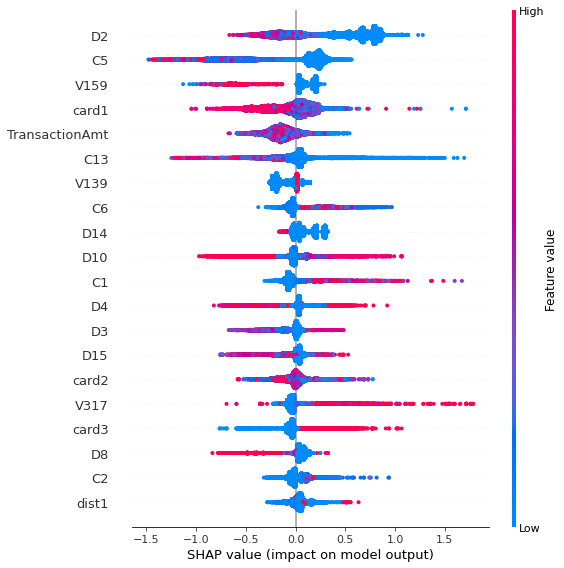

In [76]:
shap.summary_plot(shap_values, X_train[numerical_features])

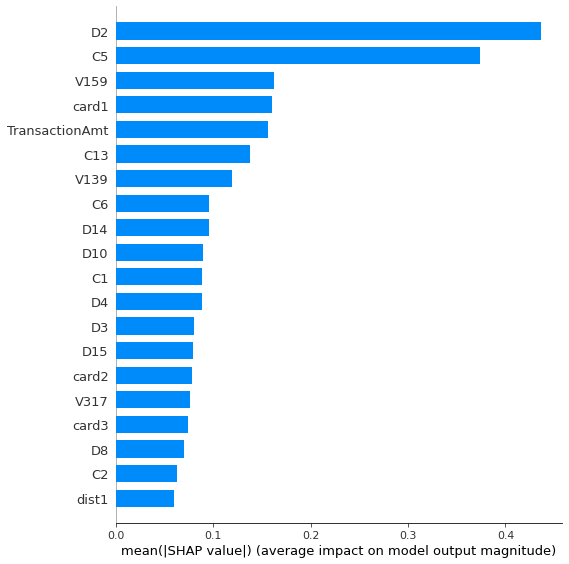

In [78]:
shap.summary_plot(shap_values, X_train[numerical_features], plot_type="bar")

In [80]:
shap_feature_importance = pd.DataFrame(list(zip(X_train.columns,np.abs(shap_values).mean(0))),columns=['feature','shap_values'])
shap_feature_importance.sort_values(by=['shap_values'],ascending=False,inplace=True)

shap_feature_importance.head(20)

,feature,shap_values
26,C11,0.436335
15,R_emaildomain,0.373473
198,V145,0.162516
3,ProductCD,0.160175
2,TransactionAmt,0.156724
23,C8,0.138320
178,V125,0.119494
16,C1,0.096019
38,D9,0.095966
34,D5,0.089164


In [81]:
shap_feats = shap_feature_importance["feature"].head(50)

In [92]:
new_feats = shap_feats.to_list()
for feat in shap_feats.to_list():
    if feat not in numerical_features:
        new_feats.remove(feat)

In [96]:
new_feats

['C11',
 'V145',
 'TransactionAmt',
 'C8',
 'V125',
 'C1',
 'D9',
 'D5',
 'addr2',
 'C13',
 'C12',
 'D10',
 'card1',
 'V303',
 'card2',
 'D3',
 'dist1',
 'card3',
 'V280',
 'C6',
 'V293',
 'C10',
 'V298',
 'C7',
 'TransactionID',
 'V56',
 'V312',
 'V296',
 'V116',
 'V68',
 'V299',
 'V24',
 'V207',
 'V267',
 'V150',
 'C14',
 'V129',
 'D6',
 'V130',
 'D7',
 'V33',
 'C9',
 'V39',
 'V73',
 'V269']

In [93]:
train.sort_values("TransactionID", inplace=True)
X_train = train.drop("isFraud", axis=1)
y_train = train["isFraud"]

In [94]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=False, test_size=0.3, random_state=42)

In [95]:
model = fit_eval(X_train, X_valid, X_test, y_train, y_valid, feats=new_feats)

[0]	validation_0-auc:0.76527
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.75076
[2]	validation_0-auc:0.76828
[3]	validation_0-auc:0.77284
[4]	validation_0-auc:0.78059
[5]	validation_0-auc:0.79591
[6]	validation_0-auc:0.80727
[7]	validation_0-auc:0.81022
[8]	validation_0-auc:0.81986
[9]	validation_0-auc:0.82582
[10]	validation_0-auc:0.82985
[11]	validation_0-auc:0.83059
[12]	validation_0-auc:0.82772
[13]	validation_0-auc:0.82674
[14]	validation_0-auc:0.83319
[15]	validation_0-auc:0.83221
[16]	validation_0-auc:0.83828
[17]	validation_0-auc:0.84040
[18]	validation_0-auc:0.84341
[19]	validation_0-auc:0.84765
[20]	validation_0-auc:0.84839
[21]	validation_0-auc:0.84537
[22]	validation_0-auc:0.84922
[23]	validation_0-auc:0.85108
[24]	validation_0-auc:0.85156
[25]	validation_0-auc:0.85442
[26]	validation_0-auc:0.85579
[27]	validation_0-auc:0.85809
[28]	validation_0-auc:0.85832
[29]	validation_0-auc:0.85814
[30]	validation_0-auc:0.85776
[31]	validation_0

Выделение признаков shap не дало улучшения.

На самом деле я сначала делал иначе - я каждый пункт делал отдельно и сравнивал с базовым пунктов - и два пункта дали мне гораздо более крутой результат - это выделение PCA и отбор критериев перестановками (или shak).